In [ ]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model, activations
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import pydicom
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from sklearn.model_selection import StratifiedGroupKFold

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import csv

In [ ]:
# Constants
# Define image size
IMAGE_SIZE = (128, 128)

### Load CSV Data

In [ ]:
# Load the CSV file and drop nulls
file_path = 'filtered_masterdata.csv'
data = pd.read_csv(file_path)
data = data[data["condition"] == "Left Subarticular Stenosis"]
data = data.dropna()

### Preprocessing

In [ ]:
# Function to split data more in line with balance of severities
def split_data(df):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, test_idx in sgkf.split(df, df['severity'], groups=df['study_id']):
        # We only need the first split, which is 80/20
        return (df.iloc[train_idx], df.iloc[test_idx])


In [ ]:

# Function to load and preprocess DICOM images
def load_and_preprocess_dicom(image_path):
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = tf.image.resize(image, IMAGE_SIZE)
    # image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [ ]:
# give a dataframe (pass train and test separately)
def preprocess_input(data):
    # Initialize lists to store images, coordinates, and severities
    images = []
    coordinates = []
    severities = []
    img_path = []

    # Process each row in the CSV file
    for index, row in data.iterrows():
        # Construct the full image path
        image_path = os.path.join(f"train_images/{row['study_id']}", f"{row['series_id']}", f"{row['instance_number']}.dcm")
        # Check if the image file exists
        if os.path.exists(image_path):
            print(f"found {image_path}")
            # Load and preprocess the image
            image = load_and_preprocess_dicom(image_path)
            images.append(image)

            img_path.append([image_path,image.shape])

            # Collect coordinates
            coordinate = [row['x'], row['y']]
            coordinates.append(coordinate)

            # Collect severities
            severities.append(row['severity'])
        else:
            img_path.append([image_path,"not found"])

    # Convert lists to numpy arrays
    images = np.array(images)
    coordinates = np.array(coordinates)

    # Handle missing coordinates by filling with a placeholder value (e.g., (0, 0))
    coordinates = np.nan_to_num(coordinates, nan=0.0)

    # One-hot encode severities
    severity_binarizer = LabelBinarizer()
    severities = severity_binarizer.fit_transform(severities)

    print(img_path)
    return (images, coordinates, severities)


In [ ]:
(train,val) = split_data(data)
(train_images, train_coordinates, train_severities) = preprocess_input(train)
(val_images, val_coordinates, val_severities) = preprocess_input(val)


# Print shapes to verify
print("Training set shapes:", train_images.shape, train_coordinates.shape, train_severities.shape)
print("Validation set shapes:", val_images.shape, val_coordinates.shape, val_severities.shape)

found train_images/4003253/2448190387/3.dcm
found train_images/4003253/2448190387/11.dcm
found train_images/4003253/2448190387/19.dcm
found train_images/4003253/2448190387/28.dcm
found train_images/4003253/2448190387/35.dcm
found train_images/4646740/3201256954/16.dcm
found train_images/4646740/3201256954/22.dcm
found train_images/4646740/3201256954/29.dcm
found train_images/4646740/3201256954/34.dcm
found train_images/4646740/3201256954/40.dcm
found train_images/11340341/1224932122/5.dcm
found train_images/11340341/1224932122/15.dcm
found train_images/11340341/1224932122/24.dcm
found train_images/11340341/1224932122/33.dcm
found train_images/11340341/1224932122/42.dcm
found train_images/11943292/403244853/8.dcm
found train_images/11943292/403244853/16.dcm
found train_images/11943292/403244853/25.dcm
found train_images/11943292/3800798510/9.dcm
found train_images/11943292/3800798510/16.dcm
found train_images/22191399/3687121182/12.dcm
found train_images/22191399/3687121182/21.dcm
found

In [ ]:
def get_best_model(checkpoint_dir):
# Get all checkpoint files
    checkpoint_files = os.listdir(checkpoint_dir)

    # Extract the validation loss from the filenames and find the one with the lowest validation loss
    best_model_path = None
    best_val_loss = float('inf')
    for file in checkpoint_files:
        if file.endswith('.h5'):
            parts = file.split('-')
            val_loss = float(parts[-1].replace('.h5', ''))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_path = os.path.join(checkpoint_dir, file)

    print(f"Loading [{best_model_path}]")

    return models.load_model(best_model_path)

In [ ]:
def callback (checkpoint_dir):
    # Set up the checkpoint callback
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_dir + '/model-{epoch:02d}-{val_loss:.4f}.h5',
                            save_weights_only=False,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    return [checkpoint_callback,early_stopping,reduce_lr]


In [ ]:
    model.fit([train_images, train_coordinates], train_severities,
        epochs=10, batch_size=32,
        validation_data=([val_images, val_coordinates], val_severities))

In [ ]:

(xsize, ysize) = IMAGE_SIZE
def create_model():
    (xsize,ysize) = IMAGE_SIZE

    # CNN for image processing
    image_cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(xsize, ysize, 1), name='conv2d_image_1'),
        BatchNormalization(name='batch_norm_image_1'),
        MaxPooling2D((2, 2), name='max_pool_image_1'),
        Conv2D(64, (3, 3), activation='sigmoid', padding='same', name='conv2d_image_2'),
        BatchNormalization(name='batch_norm_image_2'),
        MaxPooling2D((2, 2), name='max_pool_image_2'),
        Conv2D(128, (3, 3), activation='sigmoid', padding='same', name='conv2d_image_3'),
        BatchNormalization(name='batch_norm_image_3'),
        MaxPooling2D((2, 2), name='max_pool_image_3'),
        Flatten(name='flatten_image')
    ])

    # MLP for coordinates
    coordinates_mlp_model = Sequential([
        Dense(64, activation='sigmoid', input_shape=(2,), name='dense_coords_1'),
        Dense(32, activation='sigmoid', name='dense_coords_2')
    ])

    # Combining both models using Functional API
    image_input = Input(shape=(xsize, ysize, 1), name='image_input')
    coords_input = Input(shape=(2,), name='coords_input')

    cnn_output = image_cnn_model(image_input)
    mlp_output = coordinates_mlp_model(coords_input)

    combined = Concatenate(name='concat_image_coords')([cnn_output, mlp_output])
    x = Dense(128, activation='sigmoid', name='dense_combined_1')(combined)
    x = Dense(64, activation='sigmoid', name='dense_combined_2')(x)

    # Output layer (adjust 'num_classes' for your classification task)
    num_classes = 3  # Example number of classes
    output = Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Create and compile the model
    model = Model(inputs=[image_input, coords_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:

# Summary of the model
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 coords_input (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32768)        93568       ['image_input[0][0]']            
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           2272        ['coords_input[0][0]']       

# Best Model

In [ ]:

model = create_model()
model_fit(model,'checkpoint_finalized_32',32)

Epoch 1/10


2024-07-27 13:31:39.997206: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


162/162 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.5778
Epoch 1: val_loss improved from inf to 1.00223, saving model to checkpoint_finalized_32/model-01-1.0022.h5
162/162 [==============================] - 158s 979ms/step - loss: 0.9168 - accuracy: 0.5778 - val_loss: 1.0022 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 2/10
162/162 [==============================] - ETA: 0s - loss: 0.8626 - accuracy: 0.6052
Epoch 2: val_loss improved from 1.00223 to 0.88792, saving model to checkpoint_finalized_32/model-02-0.8879.h5
162/162 [==============================] - 129s 799ms/step - loss: 0.8626 - accuracy: 0.6052 - val_loss: 0.8879 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 3/10
162/162 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.6061
Epoch 3: val_loss did not improve from 0.88792
162/162 [==============================] - 134s 829ms/step - loss: 0.8486 - accuracy: 0.6061 - val_loss: 0.9648 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 4/10
162

In [ ]:

model = create_model()
model_fit(model,'checkpoint_finalized_64',64)

Epoch 1/10
81/81 [==============================] - ETA: 0s - loss: 0.9583 - accuracy: 0.5734
Epoch 1: val_loss improved from inf to 0.95790, saving model to checkpoint_finalized_64/model-01-0.9579.h5
81/81 [==============================] - 155s 2s/step - loss: 0.9583 - accuracy: 0.5734 - val_loss: 0.9579 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 0.9447 - accuracy: 0.5739
Epoch 2: val_loss improved from 0.95790 to 0.95374, saving model to checkpoint_finalized_64/model-02-0.9537.h5
81/81 [==============================] - 165s 2s/step - loss: 0.9447 - accuracy: 0.5739 - val_loss: 0.9537 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.5852
Epoch 3: val_loss improved from 0.95374 to 0.94613, saving model to checkpoint_finalized_64/model-03-0.9461.h5
81/81 [==============================] - 144s 2s/step - loss: 0.9098 - accuracy: 0.5852 - val_loss: 0.9

In [ ]:

model = create_model()
model_fit(model,'checkpoint_finalized_100',100)

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.5778
Epoch 1: val_loss improved from inf to 1.07442, saving model to checkpoint_finalized_100/model-01-1.0744.h5
52/52 [==============================] - 147s 3s/step - loss: 0.9157 - accuracy: 0.5778 - val_loss: 1.0744 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.8393 - accuracy: 0.6164
Epoch 2: val_loss improved from 1.07442 to 1.06043, saving model to checkpoint_finalized_100/model-02-1.0604.h5
52/52 [==============================] - 142s 3s/step - loss: 0.8393 - accuracy: 0.6164 - val_loss: 1.0604 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.8197 - accuracy: 0.6201
Epoch 3: val_loss improved from 1.06043 to 0.92809, saving model to checkpoint_finalized_100/model-03-0.9281.h5
52/52 [==============================] - 130s 3s/step - loss: 0.8197 - accuracy: 0.6201 - val_loss: 

In [ ]:
model=create_model()
model_fit(model,'checkpoint_32_smallerDenseNet',32)

Epoch 1/10
162/162 [==============================] - ETA: 0s - loss: 0.9451 - accuracy: 0.5676
Epoch 1: val_loss improved from inf to 0.97484, saving model to checkpoint_32_smallerDenseNet/model-01-0.9748.h5
162/162 [==============================] - 112s 693ms/step - loss: 0.9451 - accuracy: 0.5676 - val_loss: 0.9748 - val_accuracy: 0.5718 - lr: 0.0010
Epoch 2/10
162/162 [==============================] - ETA: 0s - loss: 0.8645 - accuracy: 0.5978
Epoch 2: val_loss improved from 0.97484 to 0.91331, saving model to checkpoint_32_smallerDenseNet/model-02-0.9133.h5
162/162 [==============================] - 113s 698ms/step - loss: 0.8645 - accuracy: 0.5978 - val_loss: 0.9133 - val_accuracy: 0.5811 - lr: 0.0010
Epoch 3/10
162/162 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6104
Epoch 3: val_loss improved from 0.91331 to 0.87341, saving model to checkpoint_32_smallerDenseNet/model-03-0.8734.h5
162/162 [==============================] - 111s 686ms/step - loss: 0.

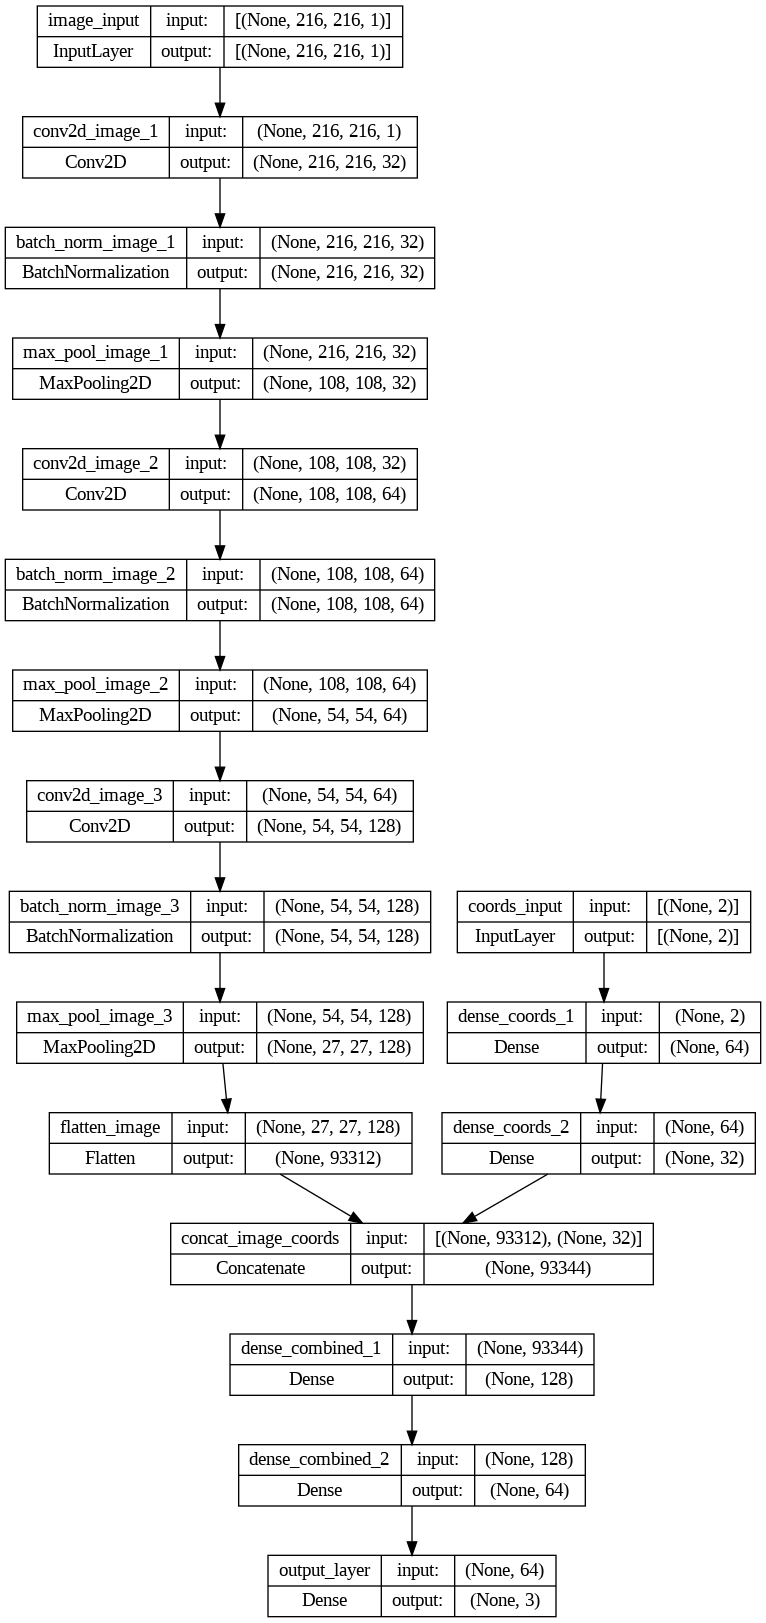

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.utils import plot_model

def create_model(IMAGE_SIZE=(216, 216), num_classes=3):
    (xsize, ysize) = IMAGE_SIZE

    # CNN for image processing
    image_input = Input(shape=(xsize, ysize, 1), name='image_input')
    x = Conv2D(32, (3, 3), activation='sigmoid', padding='same', name='conv2d_image_1')(image_input)
    x = BatchNormalization(name='batch_norm_image_1')(x)
    x = MaxPooling2D((2, 2), name='max_pool_image_1')(x)
    x = Conv2D(64, (3, 3), activation='sigmoid', padding='same', name='conv2d_image_2')(x)
    x = BatchNormalization(name='batch_norm_image_2')(x)
    x = MaxPooling2D((2, 2), name='max_pool_image_2')(x)
    x = Conv2D(128, (3, 3), activation='sigmoid', padding='same', name='conv2d_image_3')(x)
    x = BatchNormalization(name='batch_norm_image_3')(x)
    x = MaxPooling2D((2, 2), name='max_pool_image_3')(x)
    cnn_output = Flatten(name='flatten_image')(x)

    # MLP for coordinates
    coords_input = Input(shape=(2,), name='coords_input')
    y = Dense(64, activation='sigmoid', name='dense_coords_1')(coords_input)
    mlp_output = Dense(32, activation='sigmoid', name='dense_coords_2')(y)

    # Combining both models using Functional API
    combined = Concatenate(name='concat_image_coords')([cnn_output, mlp_output])
    x = Dense(128, activation='sigmoid', name='dense_combined_1')(combined)
    x = Dense(64, activation='sigmoid', name='dense_combined_2')(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Create and compile the model
    model = Model(inputs=[image_input, coords_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model()

# Plot and save the model architecture
plot_model(model, to_file='model_architecture_expanded.png', show_shapes=True, show_layer_names=True)

# Optionally display the plot in the notebook (if using Jupyter)
from IPython.display import Image
Image(filename='model_architecture_expanded.png')
